<a href="https://colab.research.google.com/github/hcy-T/ISP_python/blob/main/python_openCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

def interpolate(factor1, factor2, t):
    """Linear interpolation between two factors based on t."""
    return factor1 + (factor2 - factor1) * t

def apply_color_temperature(base_image, color_temperature, bayer_first_pixel='R'):
    """
    Apply a smooth color temperature effect to the Bayer image (16-bit), considering the first pixel of the Bayer pattern.

    Args:
    - base_image: The base image with Bayer pattern (16-bit).
    - color_temperature: The color temperature in Kelvin (e.g., 6500 for neutral).
    - bayer_first_pixel: 'R', 'G', or 'B' to specify the Bayer pattern first pixel (RGGB pattern).

    Returns:
    - Adjusted image with the color temperature applied.
    """

    # Define the color temperature ranges and corresponding r, g, b factors
    temp_ranges = [
        (2800, 1.0, 1.0, 3.625),  # <2800K -> Warm (Red push, Blue reduction)
        (3000, 1.089, 1.0, 3.382),  # 2800K to 3840K -> Slightly warm
        (3200, 1.178, 1.0, 3.319),  # 3840K to 4100K -> Neutral/slightly warm
        (3500, 1.286, 1.0, 2.874),  # 4100K to 5000K -> Slightly cool
        (4000, 1.415, 1.0, 2.482),
        (4500, 1.544, 1.0, 2.090),
        (5000, 1.673, 1.0, 1.898),
        (5500, 1.802, 1.0, 1.706),
        (6000, 1.931, 1.0, 1.514),
        (6500, 2.060, 1.0, 1.322)
    ]

    # Interpolation logic for smooth transition from 2800K to 6500K
    r_factor, g_factor, b_factor = 1.0, 1.0, 1.0

    # Handle color temperature within the range 2800K to 6500K
    if color_temperature < 2800:
        r_factor, g_factor, b_factor = 1/temp_ranges[0][1], 1/temp_ranges[0][2], 1/temp_ranges[0][3]
    elif color_temperature >= 6500:
        r_factor, g_factor, b_factor = 1/temp_ranges[-1][1], 1/temp_ranges[-1][2], 1/temp_ranges[-1][3]
    else:
        for i in range(len(temp_ranges) - 1):
            lower_temp, r1, g1, b1 = temp_ranges[i]
            upper_temp, r2, g2, b2 = temp_ranges[i + 1]

            if lower_temp <= color_temperature < upper_temp:
                # Normalize the color_temperature in this range
                t = (color_temperature - lower_temp) / (upper_temp - lower_temp)

                # Interpolate factors between the two temperature ranges
                r_factor = interpolate(1/r1, 1/r2, t)
                g_factor = interpolate(1/g1, 1/g2, t)
                b_factor = interpolate(1/b1, 1/b2, t)
                break

    # Optionally adjust based on the first pixel of the Bayer pattern
    if bayer_first_pixel == 'R':
        r_factor *= 1.05
    elif bayer_first_pixel == 'G':
        g_factor *= 1.05
    elif bayer_first_pixel == 'B':
        b_factor *= 1.05
    print(f"ct = {color_temperature}, r = {r_factor}, g = {g_factor}, b = {b_factor}")

    # Bayer pattern configuration
    if bayer_first_pixel == 'R':
        bayer_pattern = np.array([[0, 1], [3, 2]])  # RGGB
    elif bayer_first_pixel == 'G':
        bayer_pattern = np.array([[1, 0], [2, 3]])  # GRBG
    elif bayer_first_pixel == 'B':
        bayer_pattern = np.array([[2, 3], [0, 1]])  # BGGR
    else:
        raise ValueError("Invalid Bayer pattern specified. Choose from ['R', 'G', 'B']")

    # Apply the color temperature adjustment based on the Bayer pattern
    adjusted_image = base_image.copy()

    for i in range(base_image.shape[0]):
        for j in range(base_image.shape[1]):
            if bayer_pattern[i % 2, j % 2] == 0:  # Red channel
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * r_factor, 0, 65535)
            elif bayer_pattern[i % 2, j % 2] == 1:  # Green channel
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * g_factor, 0, 65535)
            elif bayer_pattern[i % 2, j % 2] == 2:  # Blue channel
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * b_factor, 0, 65535)
            else:  # Green channel (second Green)
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * g_factor, 0, 65535)
    return adjusted_image

def apply_falloff(image, falloff_percentage, image_width, image_height):
    """
    Apply radial falloff to the image based on the falloff percentage (16-bit).

    Args:
    - image: The base image to which falloff will be applied (16-bit).
    - falloff_percentage: The percentage of falloff (0-100).
    - image_width: Width of the image.
    - image_height: Height of the image.

    Returns:
    - image with falloff applied.
    """
    Y, X = np.indices((image_height, image_width))
    center_x, center_y = image_width // 2, image_height // 2
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    max_distance = np.sqrt(center_x**2 + center_y**2)
    falloff = np.clip(1 - (distance / max_distance) * (falloff_percentage / 100), 0, 1)
    #fallodd_debug = (falloff*255).astype(np.uint8)
    #cv2.imwrite(f"falloff_debug_{falloff_percentage}p.png", fallodd_debug)

    falloff_image = (image * falloff).astype(np.uint16)

    # Apply the falloff to the image (element-wise multiplication)
    return falloff_image

def load_bayer_image(filename):
    """
    Load a 16-bit Bayer image from a PNG file
    Args:
    - filename: The path to the PNG file with the 16-bit RGGB Bayer image.
    Returns:
    - raw image with Bayer pattern.
    """
    # Read the raw image as a 16-bit image
    raw_image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

    if raw_image is None:
        raise ValueError("Image not found or cannot be loaded.")

    if raw_image.dtype != np.uint16:
        raise ValueError("The image must be a 16-bit image.")
    return raw_image

def raw_RGB(raw_image):
    if raw_image.dtype != np.uint16:
        raise ValueError("The image must be a 16-bit image.")
    image_8bit = cv2.normalize(raw_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    rgb_image = cv2.cvtColor(image_8bit, cv2.COLOR_BAYER_RG2BGR)
    return rgb_image


def decompanding_image(raw_image, decompand_TL):
    """
    through decompand_TL, decompand the image.
    Args:
    - raw_image: The path to the PNG file with the 16-bit RGGB Bayer image.
    - decompand_TL: The path to the PNG file with the 16-bit RGGB Bayer image.
    Returns:
    - decompanded image (usually 32-bit).
    """
    decompanding_table = np.array(decompanding_table, dtype=np.float32)
    y, x = raw_img.sharpe()


In [84]:
def generate_color_checker_raw(image_width, image_height, bayer_first_pixel='R', color_temperature=6500, falloff_percentage=0):
    """
    Generate a ColorChecker raw image with a specified Bayer first pixel.

    Args:
    - image_width: The width of the image in pixels (must be divisible by 2).
    - image_height: The height of the image in pixels (must be divisible by 2).
    - bayer_first_pixel: 'R', 'G', or 'B' to specify the Bayer pattern first pixel (RGGB pattern).

    Returns:
    - raw_image: 16-bit raw image in Bayer RGGB pattern.
    """
    # ColorChecker Classic reference color values
    color_checker = [
        [115, 81, 68],  [194, 150,130],  [98, 122, 157],  [87, 108, 67],   [133,128, 177], [103, 189, 170], # 1rd row
        [214, 126, 44], [80, 91, 166],   [193, 90, 99],   [94, 60, 108],   [157, 188,64],  [224, 163, 46], # 2th row
        [56, 61, 150],  [70, 148, 73],   [175, 54, 60],   [231, 199, 31],  [187, 86, 149], [8, 133, 161], # 3th row
        [243, 243,243], [200, 200, 200], [160, 160, 160], [122, 122, 121], [85, 85, 85],   [52, 52, 52]# 4th row
    ]

    # Create an empty image with Bayer pattern
    raw_image = np.zeros((image_height, image_width), dtype=np.uint16)

    # Define the Bayer pattern based on the first pixel
    if bayer_first_pixel == 'R':
        bayer_pattern = np.array([[0, 1], [3, 2]])  # RGGB
    elif bayer_first_pixel == 'G':
        bayer_pattern = np.array([[1, 0], [2, 3]])  # GRBG
    elif bayer_first_pixel == 'B':
        bayer_pattern = np.array([[2, 3], [0, 1]])  # BGGR
    else:
        raise ValueError("Invalid Bayer pattern specified. Choose from ['R', 'G', 'B']")

    # ColorChecker grid size (4x6)
    grid_width, grid_height = 6, 4
    patch_height = image_height // grid_height
    patch_width = image_width // grid_width

    # Loop through each ColorChecker patch
    for row in range(grid_height):
        for col in range(grid_width):
            # Get the color intensity for this patch
            color = color_checker[row * grid_width + col]
            R, G, B = color[0], color[1], color[2]

            # Create a base image for each patch (16-bit)
            base_patch = np.zeros((patch_height, patch_width, 3), dtype=np.uint16)
            base_patch[:, :, 0] = R * 256  # Red channel (scaled to 16-bit)
            base_patch[:, :, 1] = G * 256  # Green channel (scaled to 16-bit)
            base_patch[:, :, 2] = B * 256  # Blue channel (scaled to 16-bit)

            # Assign the base patch to the corresponding Bayer channels
            for i in range(patch_height):
                for j in range(patch_width):
                    if bayer_pattern[i % 2, j % 2] == 0:
                        raw_image[row * patch_height + i, col * patch_width + j] = base_patch[i, j, 0]  # R
                    elif bayer_pattern[i % 2, j % 2] == 1:
                        raw_image[row * patch_height + i, col * patch_width + j] = base_patch[i, j, 1]  # G
                    elif bayer_pattern[i % 2, j % 2] == 2:
                        raw_image[row * patch_height + i, col * patch_width + j] = base_patch[i, j, 2]  # B
                    else:
                        raw_image[row * patch_height + i, col * patch_width + j] = base_patch[i, j, 1]  # G

    ct_image = apply_color_temperature(raw_image, color_temperature, bayer_first_pixel)

    # Apply falloff
    if falloff_percentage > 0:
        falloff_img = apply_falloff(ct_image, falloff_percentage, image_width, image_height)
        raw_image = falloff_img

    return raw_image

In [85]:
def generate_flat_field_raw(image_width, image_height, bayer_first_pixel='R', color_temperature=6500, falloff_percentage=0):
    """
    Generate a ColorChecker raw image with a specified Bayer first pixel.

    Args:
    - image_width: The width of the image in pixels (must be divisible by 2).
    - image_height: The height of the image in pixels (must be divisible by 2).
    - bayer_first_pixel: 'R', 'G', or 'B' to specify the Bayer pattern first pixel (RGGB pattern).
    - color_temperature: Color temperature in Kelvin (e.g., 6500 for neutral).
    - falloff_percentage: The percentage of falloff (0-100).

    Returns:
    - raw_image: 16-bit raw image in Bayer RGGB pattern.
    """

    # Create an empty image with Bayer pattern
    constant_value = (2<<16-1)*0.5
    raw_image = np.full((image_height, image_width), constant_value, dtype=np.uint16)

    ct_image = apply_color_temperature(raw_image, color_temperature, bayer_first_pixel)

    # Apply falloff
    if falloff_percentage > 0:
        falloff_img = apply_falloff(ct_image, falloff_percentage, image_width, image_height)
        raw_image = falloff_img


    return raw_image

ct = 3200, r = 0.8913412563667233, g = 1.0, b = 0.30129557095510695


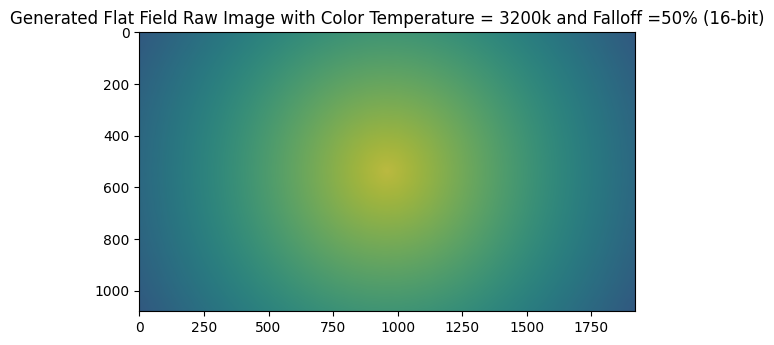

ct = 3200, r = 0.8913412563667233, g = 1.0, b = 0.30129557095510695


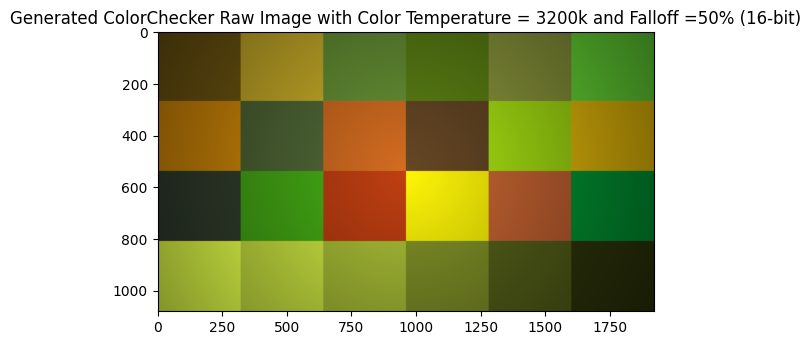

'\nCCM24_3600k_70p = load_bayer_image("/content/color_checker_with_3600k_70p_raw_16bit.png")\nplt.imshow(CCM24_3600k_70p,cmap = \'gray\')\nplt.title(f"CCM24_3600k_70p_raw")\nplt.show()\n'

In [91]:
image_width = 1920
image_height = 1080
ct=3200
ff=50
ff_image = generate_flat_field_raw(image_width, image_height, 'R', ct, ff)
ff_rgb = raw_RGB(ff_image)
# Save the image as 16-bit PNG
cv2.imwrite(f"ff_with_{ct}k_{ff}p_rgb_8bit.png", ff_rgb)
cv2.imwrite(f"ff_with_{ct}k_{ff}p_raw_16bit.png", ff_image)

# Display the raw image
plt.imshow(ff_image)
plt.title(f"Generated Flat Field Raw Image with Color Temperature = {ct}k and Falloff ={ff}% (16-bit)")
plt.show()

raw_image = generate_color_checker_raw(image_width, image_height, 'R', ct, ff)
rgb_image = raw_RGB(raw_image)
# Save the image as 16-bit PNG
cv2.imwrite(f"CCM_with_{ct}k_{ff}p_rgb_8bit.png", rgb_image)
cv2.imwrite(f"CCM_with_{ct}k_{ff}p_raw_16bit.png", raw_image)

# Display the raw image
plt.imshow(rgb_image)
plt.title(f"Generated ColorChecker Raw Image with Color Temperature = {ct}k and Falloff ={ff}% (16-bit)")
plt.show()
"""
CCM24_3600k_70p = load_bayer_image("/content/color_checker_with_3600k_70p_raw_16bit.png")
plt.imshow(CCM24_3600k_70p,cmap = 'gray')
plt.title(f"CCM24_3600k_70p_raw")
plt.show()
"""

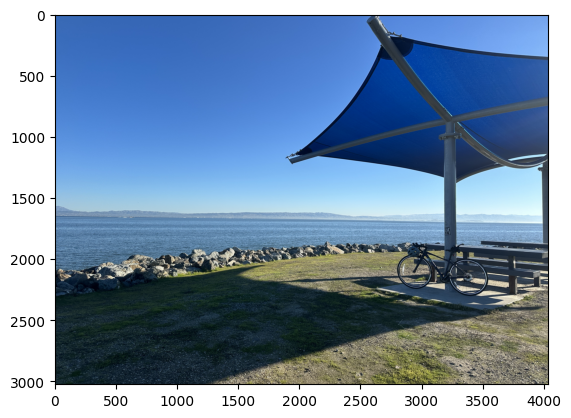